In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import pandas as pd
from IPython.display import Image
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_recall_curve, precision_recall_fscore_support, confusion_matrix

In [2]:
iris_data_ = datasets.load_iris()
iris_data = pd.DataFrame(iris_data_["data"], columns=iris_data_["feature_names"])
iris_data["Y"] = iris_data_["target"]
iris_data["Type"] = iris_data["Y"].apply(lambda y: iris_data_["target_names"][y])
del iris_data["Y"]

In [3]:
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris_data.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
118,7.7,2.6,6.9,2.3,virginica
54,6.5,2.8,4.6,1.5,versicolor
71,6.1,2.8,4.0,1.3,versicolor
102,7.1,3.0,5.9,2.1,virginica
15,5.7,4.4,1.5,0.4,setosa


In [5]:
iris_data["Type"].value_counts(normalize=True)

setosa        0.333333
virginica     0.333333
versicolor    0.333333
Name: Type, dtype: float64

/Users/z003cbx/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


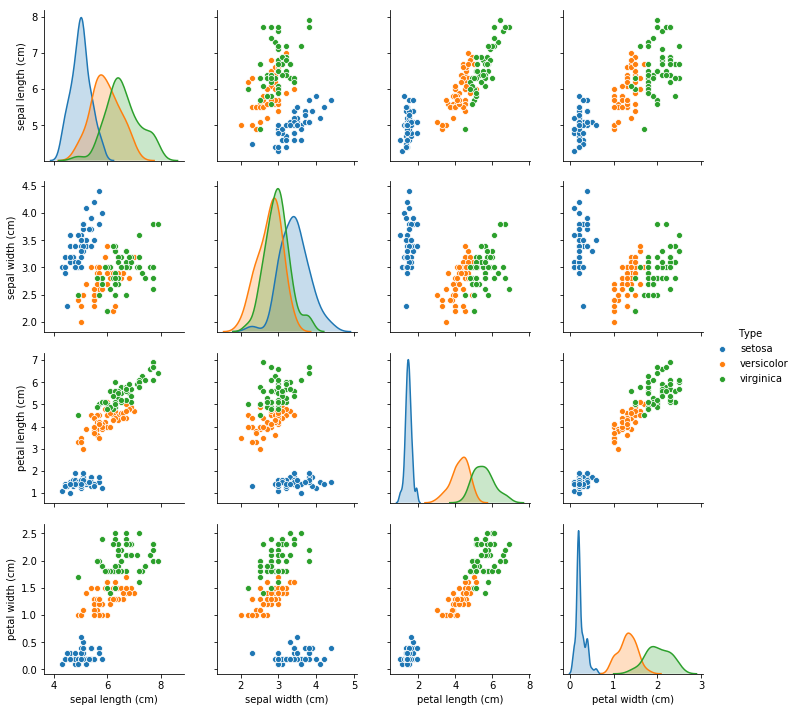

In [6]:
sns.pairplot(iris_data, "Type")

In [9]:
iris_sub = iris_data[iris_data["Type"]!="virginica"].reset_index(drop=True)

In [10]:
iris_data = iris_data[iris_data["Type"]!="setosa"].reset_index(drop=True)
iris_data["Y"] = iris_data["Type"].apply(lambda label: 1 if label == "versicolor" else 0)

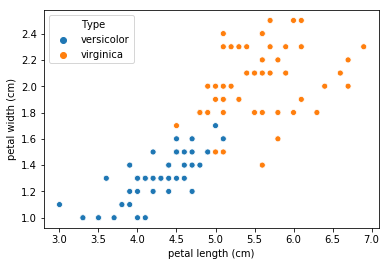

In [11]:
sns.scatterplot(iris_data.iloc[:, 2], iris_data.iloc[:, 3], hue=iris_data["Type"])

In [12]:
logistic = LogisticRegression(solver="lbfgs")
logistic.fit(iris_data.iloc[:, 2:4], iris_data["Y"])
print(np.round(logistic.intercept_,2)[0], np.round(logistic.coef_,2)[0])

17.55 [-2.78 -2.39]


w1x1 + w2x2 + w0 = 0
x2 = -w0/w2 - w1/w2 x1

x2 = 17.55/2.39 + 17.55/2.78x1



In [13]:
1/(1 + np.exp(-(np.matmul(iris_data.iloc[0, 2:4].values, logistic.coef_[0]) + logistic.intercept_[0])))

0.7601470273223496

In [14]:
y_prob_logistic = logistic.predict_proba(iris_data.iloc[:, 2:4])

In [15]:
y_prob_logistic[0]

array([0.23985297, 0.76014703])

In [16]:
confusion_matrix(iris_data["Y"],np.where(y_prob_logistic[:, 1]>=0.5, 1, 0))

array([[48,  2],
       [ 3, 47]])

In [17]:
confusion_matrix(iris_data["Y"],np.where(y_prob_logistic[:, 1]>=0.55, 1, 0))

array([[49,  1],
       [ 3, 47]])

In [18]:
confusion_matrix(iris_data["Y"],np.where(y_prob_logistic[:, 1]>=0.45, 1, 0))

array([[45,  5],
       [ 2, 48]])

In [19]:
f1_score(iris_data["Y"],np.where(y_prob_logistic[:, 1]>=0.50, 1, 0))

0.9494949494949495

In [20]:
f1_score(iris_data["Y"],np.where(y_prob_logistic[:, 1]>=0.53, 1, 0))

0.9591836734693877

In [21]:
roc_auc_score(iris_data["Y"], y_prob_logistic[:, 1])

0.9912

/Users/z003cbx/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


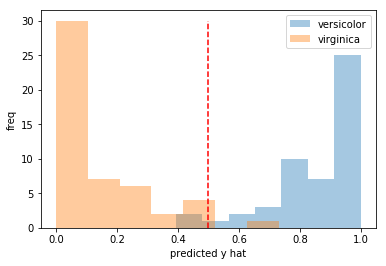

In [22]:
sns.distplot(y_prob_logistic[:, 1][np.where(iris_data["Type"]=="versicolor")], kde=False)
sns.distplot(y_prob_logistic[:, 1][np.where(iris_data["Type"]!="versicolor")], kde=False)
plt.legend(["versicolor", "virginica"])
plt.xlabel("predicted y hat")
plt.ylabel("freq")
plt.vlines(0.5,0,30,"r", "dashed")

In [23]:
fpr, tpr, th = roc_curve(iris_data["Y"], y_prob_logistic[:, 1])

In [24]:
roc_auc = roc_auc_score(iris_data["Y"], y_prob_logistic[:, 1])

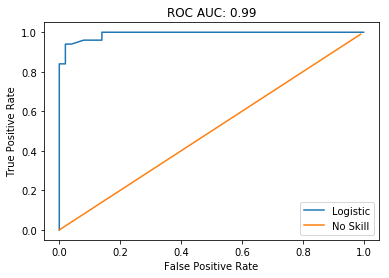

In [25]:
plt.plot(fpr, tpr)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Logistic", "No Skill"])
plt.title("ROC AUC: {:.2f}".format(roc_auc));

In [26]:
f1_scores = []
for th_ in np.arange(0, 1, 0.01):
    f1_scores.append(f1_score(iris_data["Y"],np.where(y_prob_logistic[:, 1]>=th_, 1, 0)))

max_f1_th = np.arange(0, 1, 0.01)[np.argmax(f1_scores)]
max_f1 = np.max(f1_scores)

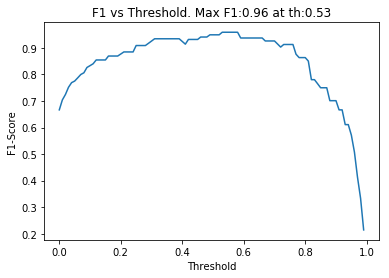

In [27]:
plt.plot(np.arange(0, 1, 0.01),f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-Score")
plt.title("F1 vs Threshold. Max F1:{:.2f} at th:{}".format(max_f1, max_f1_th));

## SVM

In [28]:
iris_sub.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [29]:
iris_sub["Type"].value_counts()

setosa        50
versicolor    50
Name: Type, dtype: int64

In [44]:
iris_sub["Y"] = iris_sub["Type"].apply(lambda cat: 0 if cat=="setosa" else 1)

In [45]:
iris_sub.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type,Y
0,5.1,3.5,1.4,0.2,setosa,0
1,4.9,3.0,1.4,0.2,setosa,0
2,4.7,3.2,1.3,0.2,setosa,0
3,4.6,3.1,1.5,0.2,setosa,0
4,5.0,3.6,1.4,0.2,setosa,0


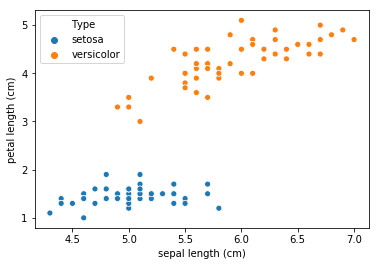

In [61]:
sns.scatterplot(iris_sub.iloc[:, 0],
                iris_sub.iloc[:, 2], 
                hue=iris_sub["Type"]);

In [62]:
perceptron = Perceptron()
perceptron.fit(iris_sub.iloc[:, :2], iris_data["Y"])
perceptron.coef_ , perceptron.intercept_

(array([[-23.2,  38.7]]), array([5.]))

In [56]:
perceptron2 = Perceptron(random_state=73)
perceptron2.fit(iris_sub.iloc[:, [0, 2]], iris_data["Y"])
perceptron2.coef_ , perceptron2.intercept_

(array([[ 3.2, -8.1]]), array([1.]))

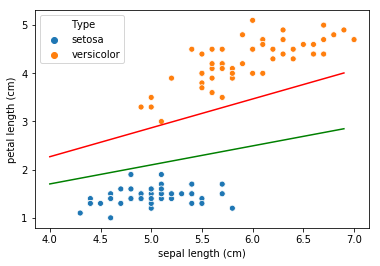

In [63]:
x1 = np.arange(4, 7, 0.1)
x2 = -1 * (perceptron.intercept_[0] + perceptron.coef_[0][0]*x1)/perceptron.coef_[0][1]
x3 = -1 * (perceptron2.intercept_[0] + perceptron2.coef_[0][0]*x1)/perceptron2.coef_[0][1]
sns.scatterplot(iris_sub.iloc[:, 0],
                iris_sub.iloc[:, 2], 
                hue=iris_sub["Type"]);
plt.plot(x1, x2, color="red")
plt.plot(x1, x3, color="green")

In [72]:
svc = SVC(kernel="linear")
svc.fit(iris_sub.iloc[:, [0, 2]], iris_data["Y"])
svc.intercept_, svc.coef_

(array([3.82320082]), array([[-0.02335033, -1.42690456]]))

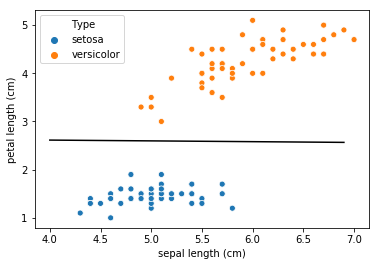

In [74]:
x1 = np.arange(4, 7, 0.1)
x4 = -1 * (svc.intercept_[0] + svc.coef_[0][0]*x1)/svc.coef_[0][1]

sns.scatterplot(iris_sub.iloc[:, 0],
                iris_sub.iloc[:, 2], 
                hue=iris_sub["Type"]);

plt.plot(x1, x4, color="black");

## RBF Kernel

In [78]:
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Type,Y
0,7.0,3.2,4.7,1.4,versicolor,1
1,6.4,3.2,4.5,1.5,versicolor,1
2,6.9,3.1,4.9,1.5,versicolor,1
3,5.5,2.3,4.0,1.3,versicolor,1
4,6.5,2.8,4.6,1.5,versicolor,1


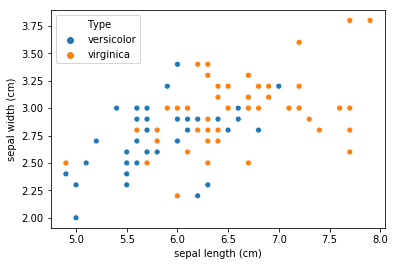

In [108]:
sns.scatterplot(iris_data.iloc[:, 0],
                iris_data.iloc[:, 1], 
                hue=iris_data["Type"]);

In [141]:
svm_lin = SVC(kernel="linear")
svm_lin.fit(iris_data.iloc[:, 0:2], iris_data["Y"])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [138]:
def plot_decision_boundary(X, clf, col):
    h = .02 
    x_min, x_max = X[:, 0].min() - 0.05, X[:, 0].max() + 0.05
    y_min, y_max = X[:, 1].min() - 0.05, X[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors=col, linewidths=0.3)

In [143]:
svm_rbf = SVC(C=100000, kernel="rbf", gamma="auto")
svm_rbf.fit(iris_data.iloc[:, 0:2], iris_data["Y"])

SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

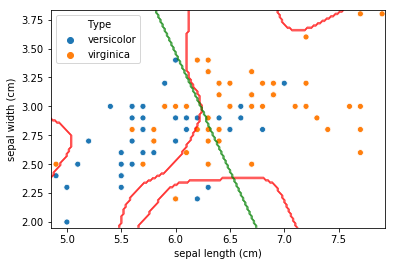

In [144]:
sns.scatterplot(iris_data.iloc[:, 0],
                iris_data.iloc[:, 1], 
                hue=iris_data["Type"]);
plot_decision_boundary(iris_data.iloc[:,:2].values, svm_rbf, "red")
plot_decision_boundary(iris_data.iloc[:,:2].values, svm_lin, "green")

# Decision Trees

In [145]:
clf_dt = DecisionTreeClassifier()

In [146]:
clf_dt.fit(iris_data.iloc[:, 2:4], iris_data["Type"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [ ]:
export_graphviz(clf_dt, out_file="decision_tree.dot", feature_names = iris_data.columns[2:4],
               class_names = iris_data["Type"], filled=True)

In [151]:
!dot -Tpng decision_tree.dot -o decision_tree.png -Gdpi=600

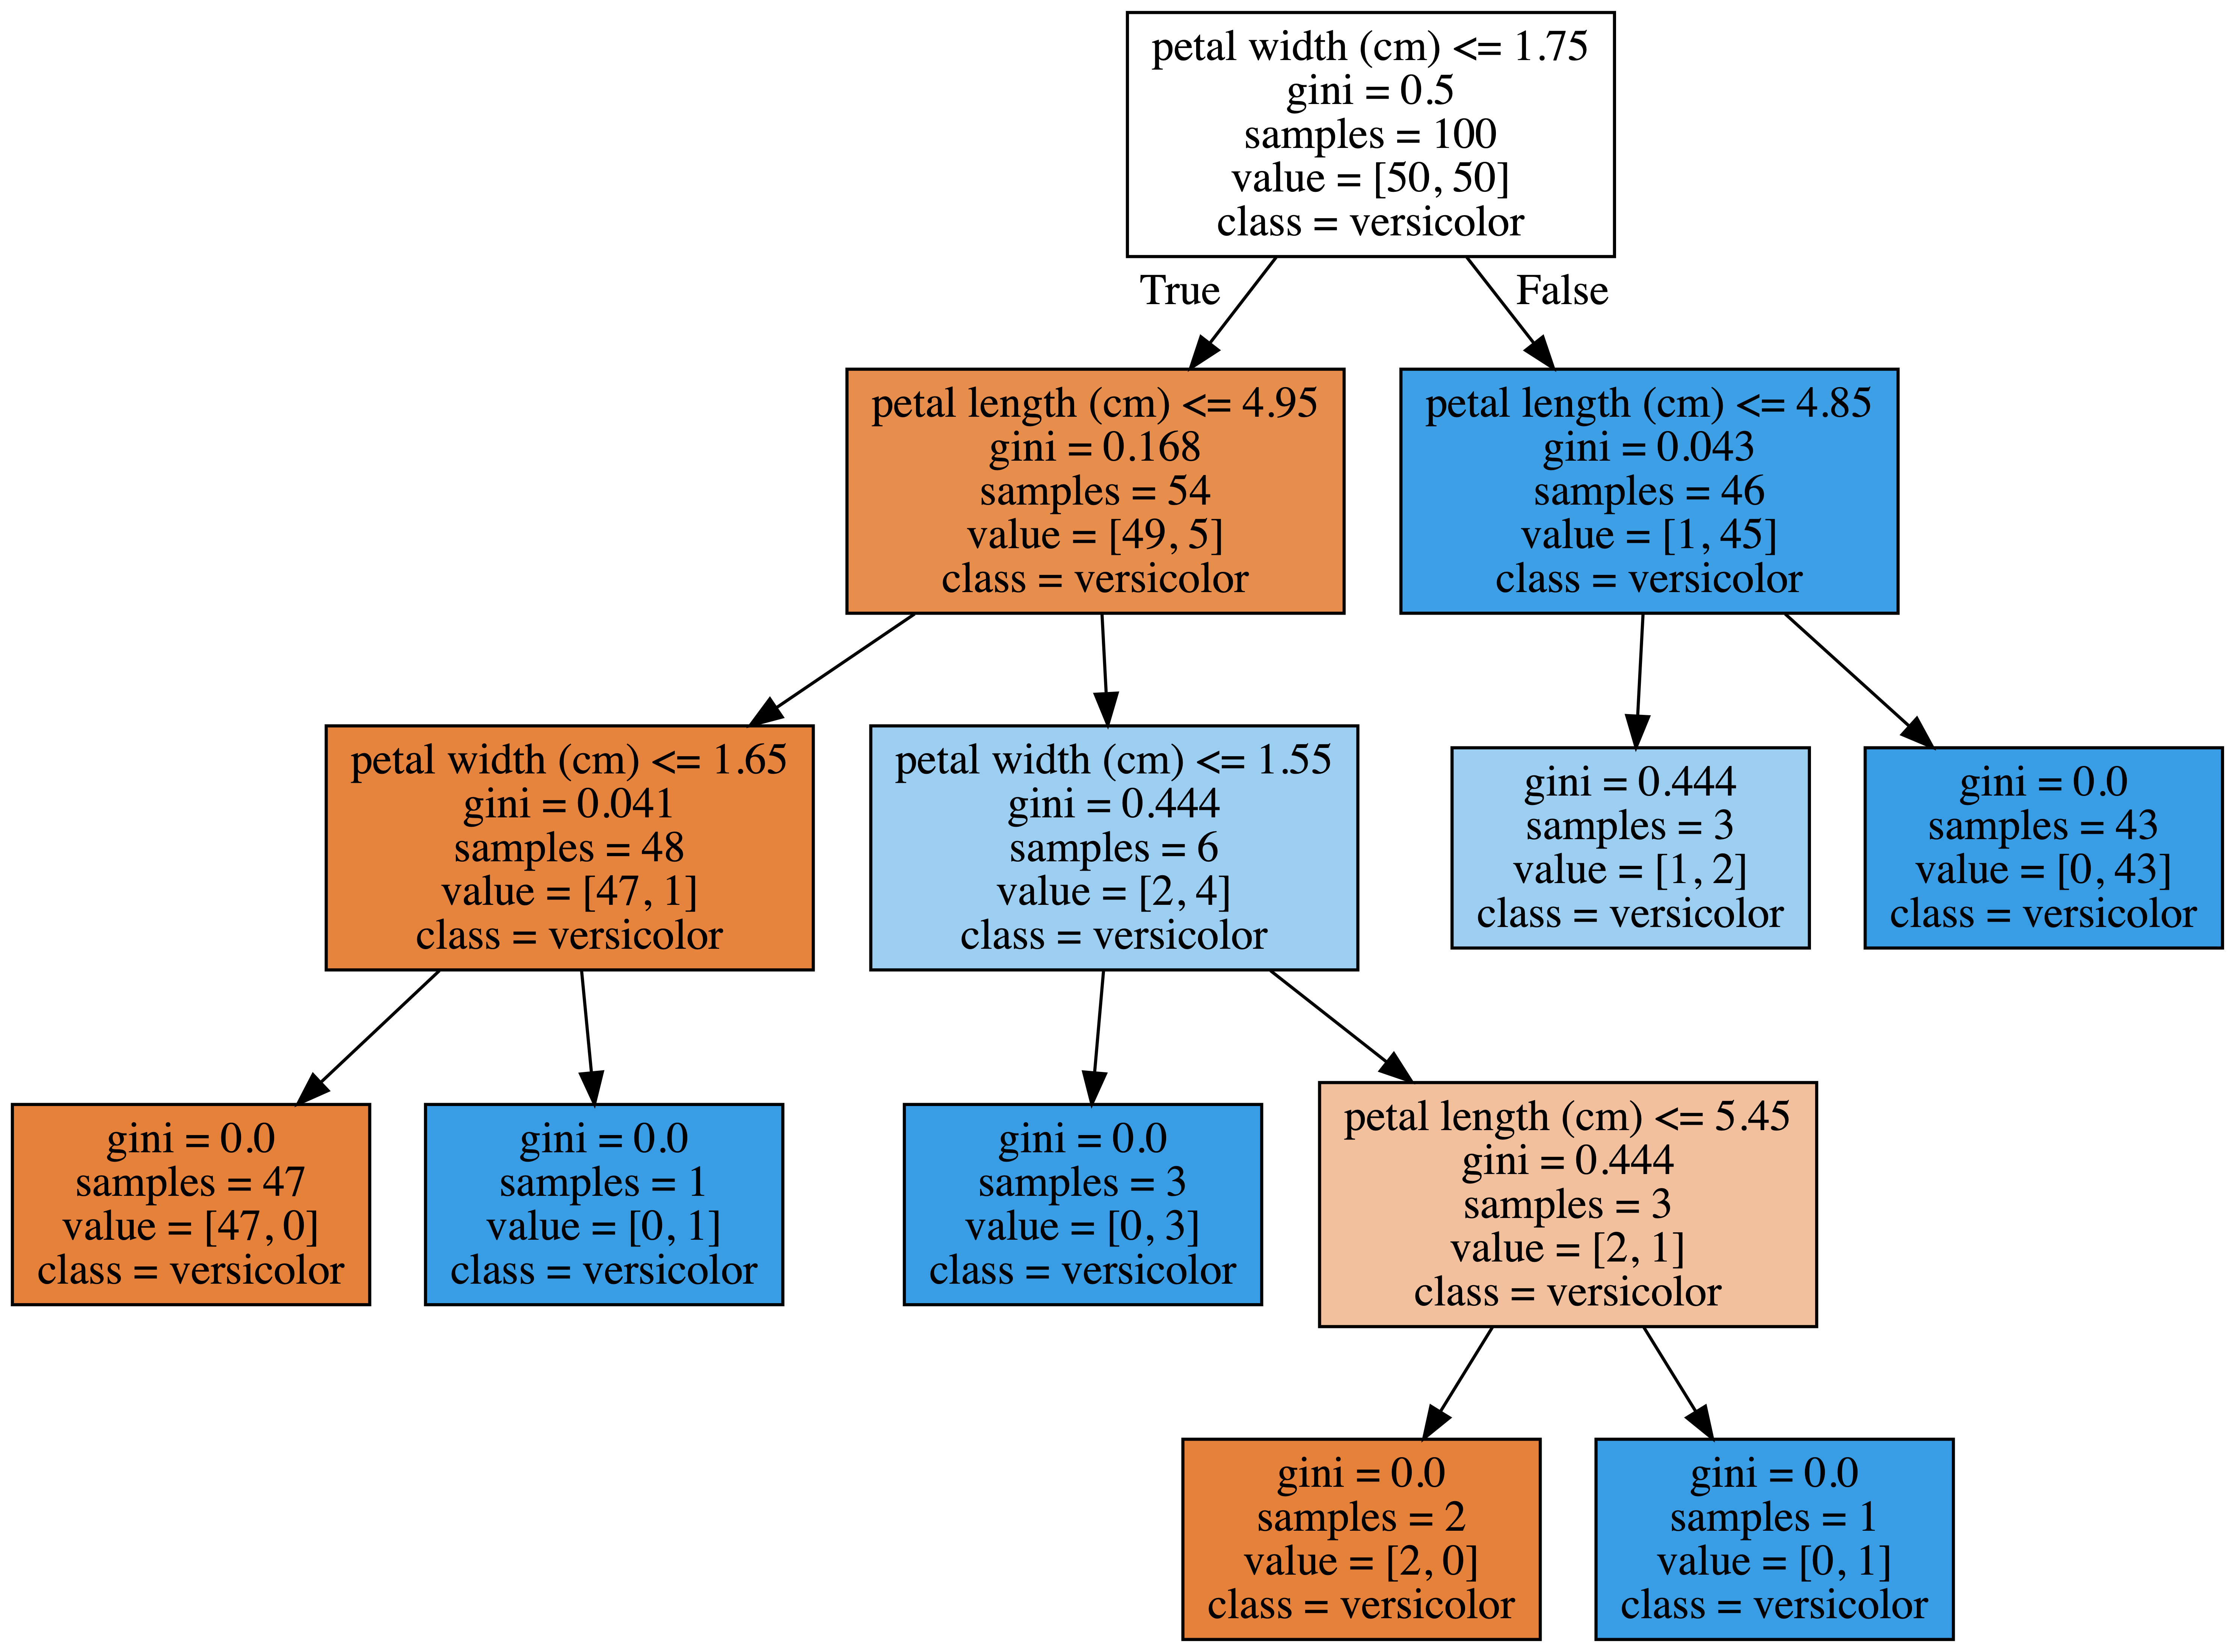

In [152]:
Image(filename = "decision_tree.png")

In [ ]:
# Visualize data
dot_data = tree.export_graphviz(clf,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

In [ ]:
export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, precision = 2, filled = True)

Image(filename = 'tree_limited.png')